In [30]:
import networkx as nx
import numpy as np
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

import nibabel as nib
import numpy as np
import networkx as nx
from skimage.measure import marching_cubes
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from glob import glob
import nibabel.freesurfer.mghformat as mghf # read mgz images
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns


In [91]:
#Functions definition: all of the functions called at some point during the analysis are defined here

def plot_matrix_histogram(matrix):
    # Convert matrix to a 1D array of values
    values = matrix.values.flatten() if isinstance(matrix, pd.DataFrame) else matrix.flatten()
    
    values = values[values != 0]
    mean = np.mean(values)
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=30, color='skyblue', edgecolor='black', label='non-zero entries')
    plt.xlabel('Matrix Entry Values')
    plt.yscale('log')
    plt.ylabel('Frequency')
    #plt.axhline(10, 0, 1000)
    plt.axvline(mean, 0, 100000, label= f"mean = {round(mean, 4)}")
    #plt.title('Histogram of Matrix Entries')
    plt.legend()
    plt.show()


def rescale_coordinates(node_positions, skeleton_coords):
    '''
    This function translates the coordinates of the nodes in the graph into the SDR of the skeleton data
    '''
    graph_min = node_positions.min(axis=0)
    graph_max = node_positions.max(axis=0)
    skeleton_min = skeleton_coords.min(axis=0)
    skeleton_max = skeleton_coords.max(axis=0)

    normalized_node_positions = (
        (node_positions - graph_min) / (graph_max - graph_min)
    ) * (skeleton_max - skeleton_min) + skeleton_min

    return normalized_node_positions


def louvain_with_target_communities(graph, target_communities, initial_resolution=5, max_iter=100, tolerance=1):
    """
    Run Louvain community detection repeatedly, adjusting the resolution and handling oscillations 
    until the target number of communities is reached.

    Parameters:
    - graph: NetworkX graph on which to perform community detection.
    - target_communities: The desired number of communities.
    - initial_resolution: Starting value for the resolution parameter (default is 1.0).
    - max_iter: Maximum number of iterations to try to reach the target (default is 100).
    - tolerance: Initial tolerance for adjusting the resolution (default is 0.1).

    Returns:
    - A tuple of (partition, num_communities, final_resolution), where:
        - partition is a dictionary mapping each node to its community.
        - num_communities is the number of communities in the final partition.
        - final_resolution is the final value of the resolution parameter used.
    """
    resolution = initial_resolution
    last_num_communities = None
    oscillation_count = 0  # Counter to track oscillations

    for i in range(max_iter):
        # Perform Louvain community detection with the current resolution
        partition = nx.community.louvain_communities(graph, resolution=resolution)
        num_communities = len(list(partition))
        print(f"Cycle {i +1}, resolution = {resolution}, number of communities = {num_communities}")

        # Check if the target number of communities has been achieved
        if num_communities == target_communities:
            print(f"Target achieved in {i+1} iterations with resolution={resolution}.")
            return partition, num_communities, resolution

        # Check for oscillation by comparing with the previous number of communities
        if last_num_communities is not None and (
            (num_communities > target_communities and last_num_communities < target_communities) or
            (num_communities < target_communities and last_num_communities > target_communities)
        ):
            oscillation_count += 1
            if oscillation_count >= 2:
                # Halve the tolerance if we detect oscillation
                tolerance /= 2
                oscillation_count = 0  # Reset oscillation count
                print(f"Oscillation detected. Reducing tolerance to {tolerance}")

        # Update the resolution based on whether we need more or fewer communities
        if num_communities > target_communities:
            resolution -= tolerance  # Increase resolution to reduce the number of communities
        else:
            resolution += tolerance  # Decrease resolution to increase the number of communities

        # Update last number of communities for the next iteration
        last_num_communities = num_communities

    print("Warning: Target number of communities not achieved within max_iter.")
    return partition, num_communities, resolution



def assign_voxels_to_nearest_nodes(node_coords, binary_volume, communities,nodes_names):
    """
    Assign each voxel in a binary MRI volume to the community of the nearest node.

    Parameters:
    - node_coords: A list or array of 3D coordinates for each node in the network (shape: [num_nodes, 3]).
    - binary_volume: A 3D NumPy array representing the binary MRI volume (1 for voxels to include, 0 otherwise).
    - communities: A list of lists, where each sublist contains the indices of nodes belonging to a specific community.

    Returns:
    - voxel_node_map: A 3D array where each voxel contains the index of the nearest node.
    - voxel_community_map: A 3D array where each voxel contains the community index of the nearest node.
    """
    # Convert the list of lists `communities` to a dictionary mapping each node to its community index
    node_to_community = {}
    for community_index, nodes in enumerate(communities):
        for node in nodes:
            node_to_community[node] = community_index + 1
    # Get the shape of the volume
    volume_shape = binary_volume.shape

    # Get the coordinates of all active (1-valued) voxels in the binary volume
    voxel_indices = np.argwhere(binary_volume > 0)  # N x 3 array of voxel coordinates

    # Build a KD-tree for the node coordinates to enable efficient nearest-neighbor search
    tree = cKDTree(node_coords)

    # Find the index of the closest node for each voxel coordinate
    _, nearest_node_indices = tree.query(voxel_indices)

    # Create empty maps to store the nearest node and community indices for each voxel
    voxel_node_map = np.zeros(volume_shape, dtype=int)
    voxel_community_map = np.zeros(volume_shape, dtype=int)

    # Populate the voxel_node_map and voxel_community_map
    for voxel, node_index in zip(voxel_indices, nearest_node_indices):
        voxel_node_map[tuple(voxel)] = node_index
        node = nodes_names[node_index]
        voxel_community_map[tuple(voxel)] = node_to_community.get(node, -1)  # -1 if node not in any community

    return voxel_node_map, voxel_community_map



def plot_3d_matrix_general(matrix, title, colors):
    """
    Plots a brain parcellation, with each community label depicted as a different color.

    Parameters:
    - matrix: 3D NumPy array with multiple unique values.
    """
    # Identify unique values in the matrix, excluding zero
    unique_values = np.unique(matrix)
    unique_values = unique_values[unique_values != 0]  # Exclude zero
    print(len(unique_values))
    
    # Set up a colormap
    #colors = plt.cm.get_cmap("gist_rainbow", len(unique_values))  # Use a colormap with enough colors
    
    # Create a 3D plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each unique value in the matrix with a different color
    for i, value in enumerate(unique_values):
        # Get the coordinates of all entries with the current value
        voxel_indices = np.argwhere(matrix == value)
        
        # Separate the coordinates into x, y, and z components
        x, y, z = voxel_indices[:, 0], voxel_indices[:, 1], voxel_indices[:, 2]
        
        # Plot the points with the color corresponding to the current value
        ax.scatter(x, y, z, c=[colors(i)],   alpha =.3, s= 5)#label=f'Value {value}',marker='o',

    # Set labels, title, and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize= 20)
    #ax.legend()
    plt.show()


def graph_to_dataframe(graph):
    """
    Convert a graph into a Pandas DataFrame, with each node as a row and node attributes as columns.

    Parameters:
    - graph: A NetworkX graph with nodes and attributes.

    Returns:
    - df: A Pandas DataFrame where each row represents a node, and columns represent node attributes.
    """
    # Extract node data from the graph
    node_data = []
    for node, attributes in graph.nodes(data=True):
        # Include the node ID in the attributes dictionary
        attributes['node'] = node
        node_data.append(attributes)

    # Convert the list of node dictionaries into a DataFrame
    df = pd.DataFrame(node_data)

    # Optional: Reorder to have 'node' as the first column
    if 'node' in df.columns:
        cols = ['node'] + [col for col in df.columns if col != 'node']
        df = df[cols]

    return df



def assign_parcellation_labels_to_nodes_direct(node_voxel_coords, mgz_file_path):
    """
    Assigns a parcellation label to each node based on its voxel coordinates in the brain.

    Parameters:
    - node_voxel_coords: A DataFrame with 'x', 'y', 'z' columns for node voxel coordinates.
    - mgz_file_path: Path to the MGZ file containing the parcellation map.

    Returns:
    - labeled_nodes: A DataFrame with an additional 'parcellation_label' column for each node.
    """
    # Verify that node_voxel_coords has the required columns
    if not all(col in node_voxel_coords.columns for col in ['x', 'y', 'z']):
        raise ValueError("node_voxel_coords must contain 'x', 'y', 'z' columns")

    # Load the parcellation volume from the MGZ file
    parcellation_img = nib.load(mgz_file_path)
    parcellation_data = parcellation_img.get_fdata()

    # Check the shape of the parcellation volume
    max_x, max_y, max_z = parcellation_data.shape
    #print("Parcellation data shape:", parcellation_data.shape)

    # Directly use voxel coordinates to get labels
    labels = []
    for x, y, z in node_voxel_coords[['x', 'y', 'z']].values:
        # Check if the voxel coordinates are within bounds
        if 0 <= x < max_x and 0 <= y < max_y and 0 <= z < max_z:
            label = parcellation_data[int(x), int(y), int(z)]  # Get the label at this voxel
        else:
            print(f"Voxel ({x}, {y}, {z}) is out of bounds")
            label = -1  # Assign -1 if the node is out of bounds
        labels.append(label)

    # Create a new DataFrame with the 'parcellation_label' column
    labeled_nodes = node_voxel_coords.copy()
    labeled_nodes['parcellation_label'] = labels

    return labeled_nodes



def matrices_to_nonzero_lists(matrix1, matrix2):
    
    # Flatten the matrices and filter out zeros
    list1 = matrix1[matrix1 != 0].flatten().tolist()
    list2 = matrix2[matrix2 != 0].flatten().tolist()
    
    return list1, list2



def compare_label_sets(labels_method1, labels_method2):
    """
    Compare two sets of labels using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).

    Parameters:
    - labels_method1: List or array of labels from the first method (e.g., node-based labels).
    - labels_method2: List or array of labels from the second method (e.g., voxel-based labels).

    Returns:
    - ari: Adjusted Rand Index score.
    - nmi: Normalized Mutual Information score.
    """
    # Ensure that labels are in the same format (e.g., both lists or arrays)
    labels_method1 = np.array(labels_method1)
    labels_method2 = np.array(labels_method2)

    # Compute Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(labels_method1, labels_method2)

    # Compute Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(labels_method1, labels_method2)

    return ari, nmi



def label_correlation_heatmap(labels_method1, labels_method2):
    ''' 
    Generates a co-occurence table between the two lists of labels

    Parameters:
    labels_method1
    labels_method_2

    Returns: 
    contingency_table: co-occurence matrix of the two labels sets
    
    '''
    # Ensure that both sets of labels are arrays
    labels_method1 = np.array(labels_method1)
    labels_method2 = np.array(labels_method2)

    # Create a contingency table (confusion matrix)
    contingency_table = pd.crosstab(labels_method1, labels_method2)
    #contingency_table = np.log(contingency_table.to_numpy())
    # Plot the heatmap using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=False, fmt="d", cmap="YlGnBu", cbar=True)
    plt.xlabel("Parcellations")
    plt.ylabel("Communities")
    plt.title("Correlation Heatmap between Label Sets")
    plt.show()

    return contingency_table


def normalize_contingency_table(contingency_table):
    """
    Normalize a contingency table by dividing each cell by the sum of entries in its row and column.

    Parameters:
    - contingency_table: A pandas DataFrame representing the contingency table (e.g., from pd.crosstab).

    Returns:
    - normalized_table: A pandas DataFrame with normalized values.
    """
    # Initialize an empty DataFrame with the same index and columns as the contingency table
    normalized_table = pd.DataFrame(index=contingency_table.index, columns=contingency_table.columns, dtype=float)

    # Iterate over each cell in the contingency table to normalize
    for row in contingency_table.index:
        for col in contingency_table.columns:
            row_sum = contingency_table.loc[row].sum()   # Sum of the row
            col_sum = contingency_table[col].sum()       # Sum of the column
            if row_sum + col_sum != 0:
                normalized_table.loc[row, col] = contingency_table.loc[row, col] / (row_sum + col_sum)
            else:
                normalized_table.loc[row, col] = 0  # Handle division by zero, if both sums are zero

    return normalized_table



In [ ]:

graph = nx.read_gpickle('PR-graphomics/sk-multiscale_bin.pickle')

template = datasets.fetch_atlas_basc_multiscale_2015()

template.keys()

img = nib.load(template.scale007)

volume = img.get_fdata()
bin_volume = volume != 0

skeleton = skeletonize(bin_volume)


sx, sy, sz = np.where(skeleton)
skeleton_coords = np.vstack((sx, sy, sz)).T

#Coordinates normalization (it's already done in the weighted one)
node_positions = np.array(graph.nodes, dtype=float)
normalized_node_positions = rescale_coordinates(node_positions, skeleton_coords)
for i, node in enumerate(graph.nodes()):
    graph.nodes[node]['x'], graph.nodes[node]['y'], graph.nodes[node]['z'] = normalized_node_positions[i]



In [26]:

communities = nx.community.louvain_communities(graph)
len(communities)

8

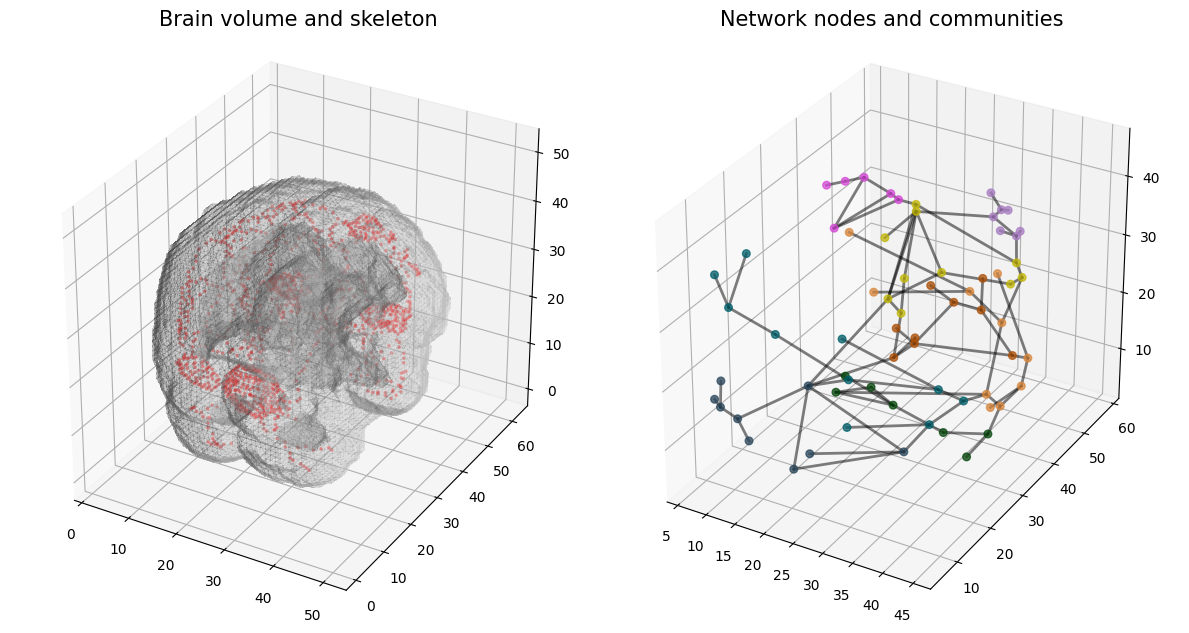

In [89]:

fig = plt.figure(figsize=(12, 16))
ax = plt.subplot(121, projection = '3d')

verts, faces, normals, values = marching_cubes(volume, 0)

    # draw the object volume
ptx, pty, ptz = verts.T
ax.plot_trisurf(ptx, pty, faces, ptz, 
                    color='lightgray',
                    alpha=0.15,
                    antialiased=False, 
                    linewidth=0.0
                )
ax.set_box_aspect((np.ptp(ptx), np.ptp(pty), np.ptp(ptz)))
_ = ax.set_title('Brain volume and skeleton', fontsize=15)

ax.scatter(sx, sy, sz, color='r', marker='o', s=3, alpha=0.35)

ax1 = plt.subplot(122, projection = '3d')

# Plot nodes by community in ax1
colors = list(mcolors.XKCD_COLORS.keys())
np.random.shuffle(colors)
for com, color in zip(communities, colors):
    com_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y'], graph.nodes[node]['z']) for node in com]
    ax1.scatter(*zip(*com_coords), color=color, marker='o', s=30, alpha=0.75)

# Plot edges based on node coordinates in ax1
for ex, ey in graph.edges():
    x_coords = [graph.nodes[ex]['x'], graph.nodes[ey]['x']]
    y_coords = [graph.nodes[ex]['y'], graph.nodes[ey]['y']]
    z_coords = [graph.nodes[ex]['z'], graph.nodes[ey]['z']]
    ax1.plot(x_coords, y_coords, z_coords, color='k', linewidth=2, alpha=0.5)

# Set plot labels and title for ax1
ax1.set_box_aspect((np.ptp(sx), np.ptp(sy), np.ptp(sz)))
ax1.set_title('Network nodes and communities', fontsize=15)
plt.tight_layout()
plt.show()

7


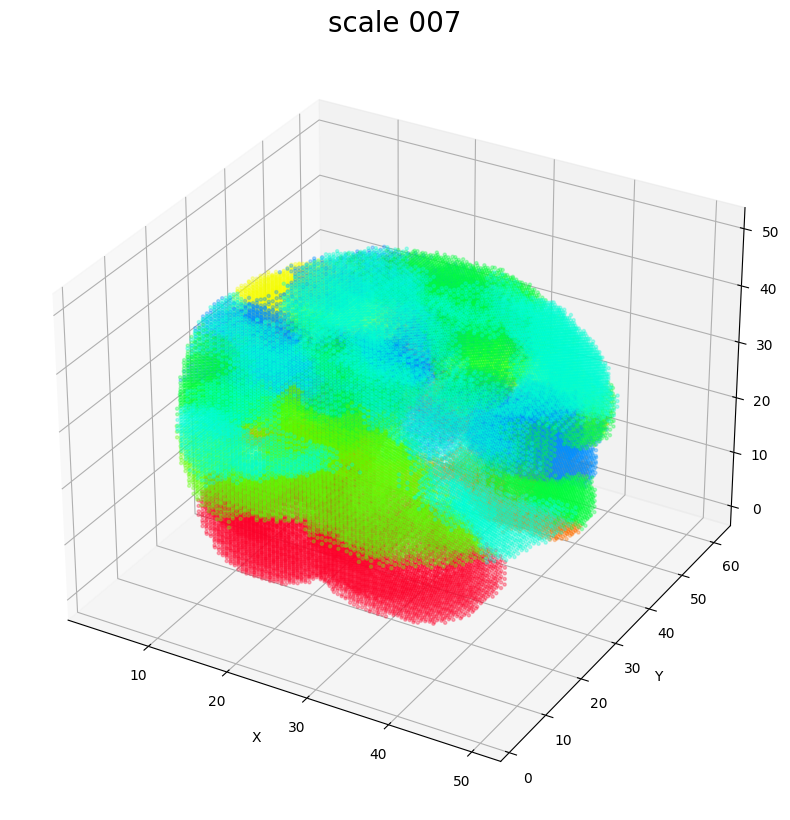

8


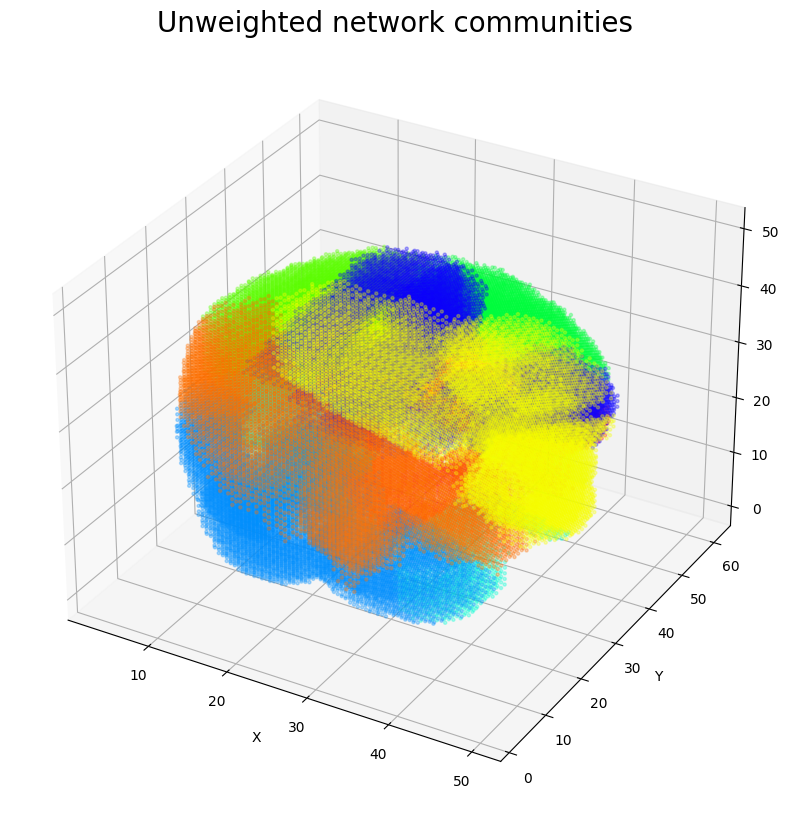

64


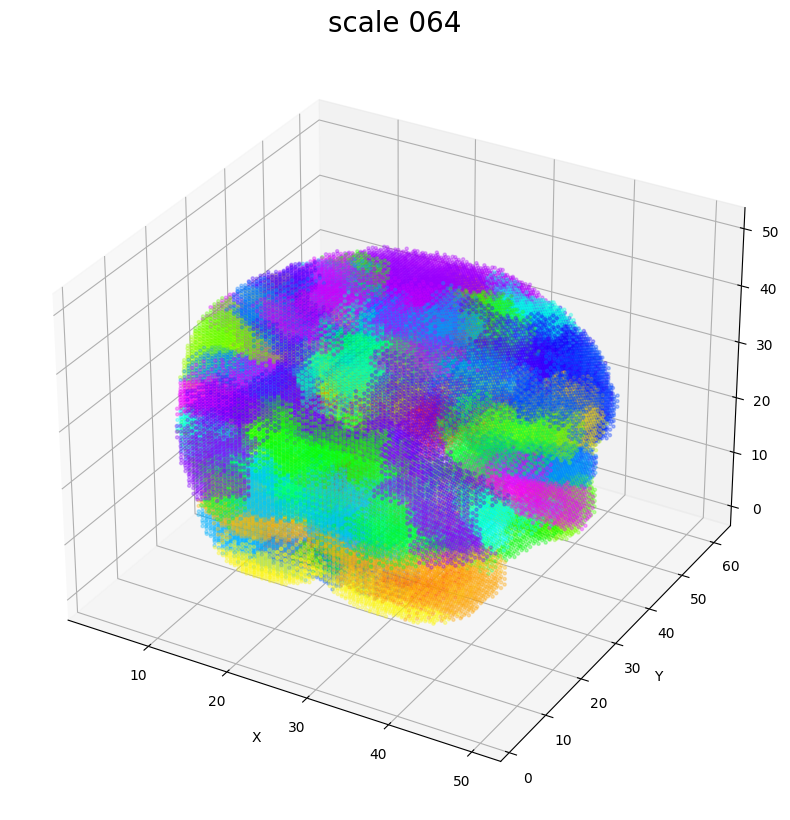

67


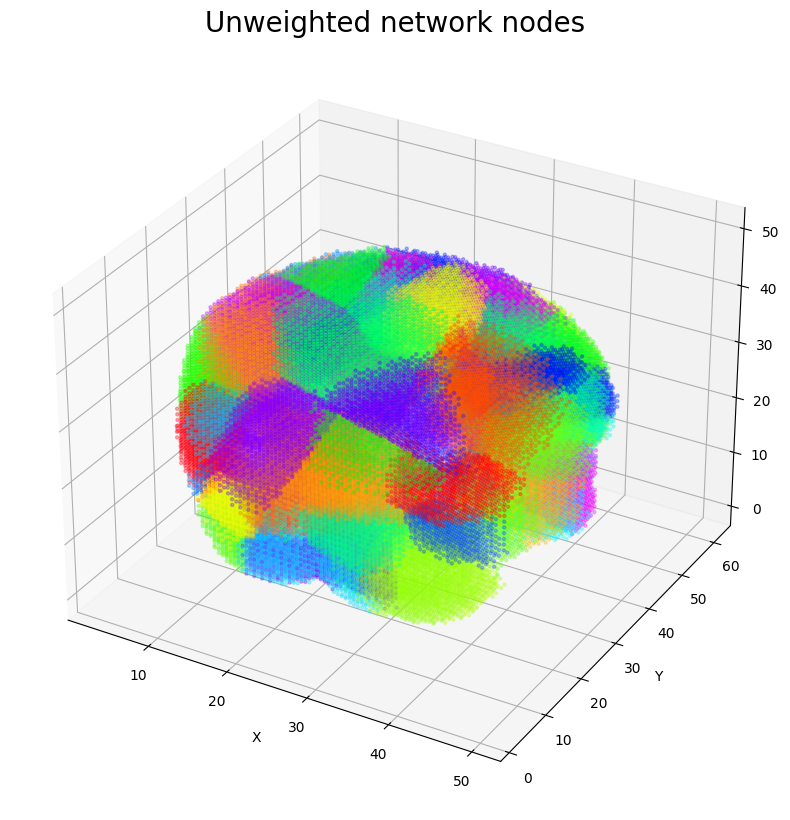

In [54]:

nodes_names = list(graph.nodes()) #the nodes names are the same in the two graphs 
nodes_coords = [(graph.nodes[node]['x'], graph.nodes[node]['y'], graph.nodes[node]['z']) for node in nodes_names]

node_map, community_map = assign_voxels_to_nearest_nodes(nodes_coords,  bin_volume, communities, nodes_names)
#original parcellation 
colors = plt.cm.get_cmap("gist_rainbow", 10)
n_colors  = plt.cm.get_cmap("gist_rainbow", len(graph.nodes()))

plot_3d_matrix_general(volume, 'scale 007',colors)
plot_3d_matrix_general(community_map, 'Unweighted network communities',colors)

plot_3d_matrix_general(nib.load(template.scale064).get_fdata(), 'scale 064',n_colors)
plot_3d_matrix_general(node_map, 'Unweighted network nodes',n_colors)

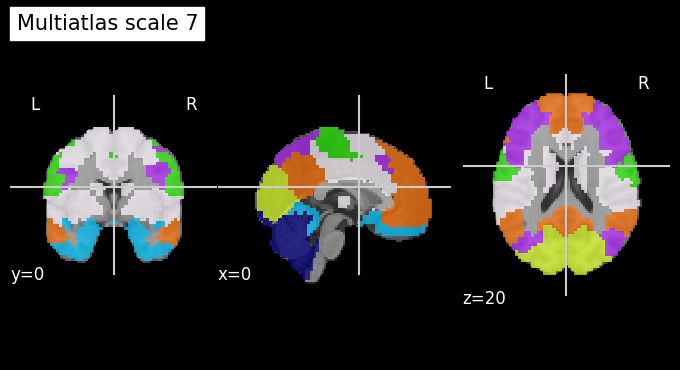

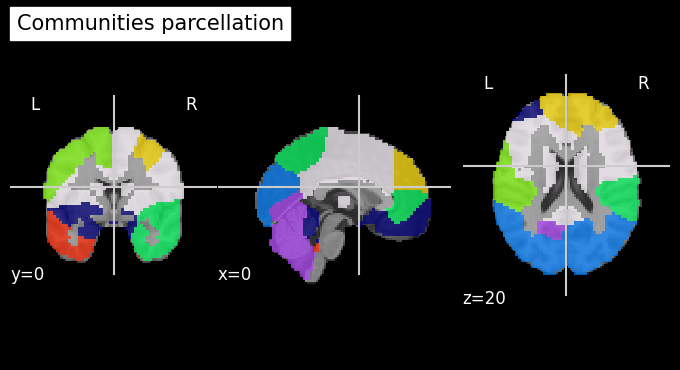

In [82]:
affine = img.affine
community_map = community_map.astype(float)

planes = [0,0,20]
plotting.plot_roi(template.scale007, title="Multiatlas scale 7", black_bg=True, cut_coords=planes)
plotting.plot_roi(nib.Nifti1Image(community_map, affine=affine), black_bg=True, cut_coords=planes, title="Communities parcellation")

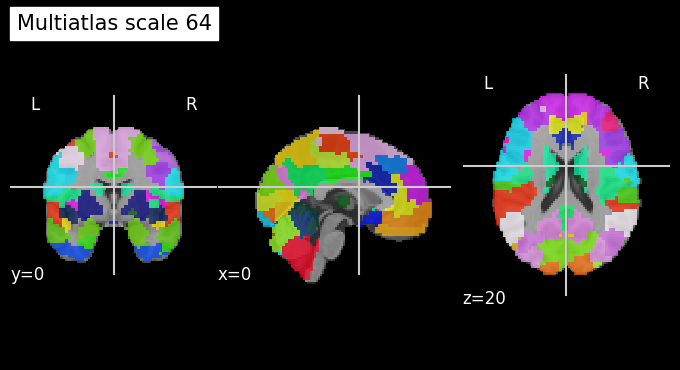

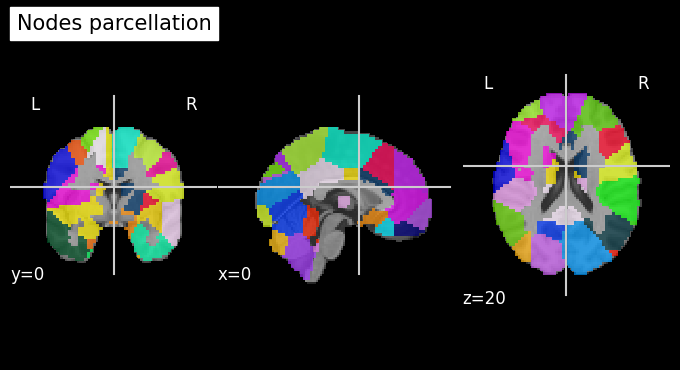

In [83]:
affine = img.affine
node_map = node_map.astype(float)
plotting.plot_roi(template.scale064, title="Multiatlas scale 64", black_bg=True, cut_coords=planes)
plotting.plot_roi(nib.Nifti1Image(node_map, affine=affine), cut_coords=planes, black_bg=True, title="Nodes parcellation")

In [ ]:
node_list, scale64_list = matrices_to_nonzero_lists(node_map,nib.load(template.scale064).get_fdata())
comm_list, scale7_list = matrices_to_nonzero_lists(community_map,nib.load(template.scale007).get_fdata())



(57790, 57790)

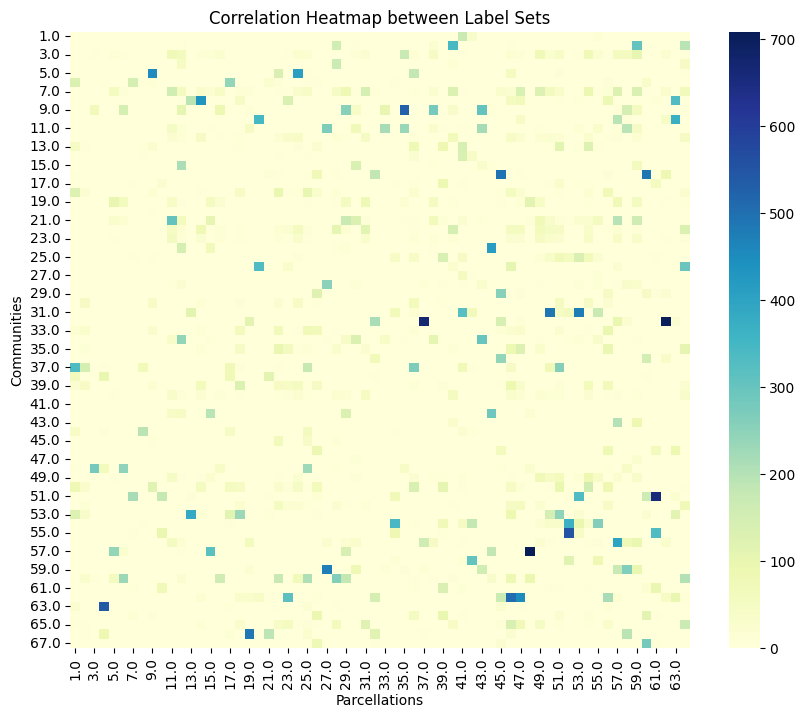

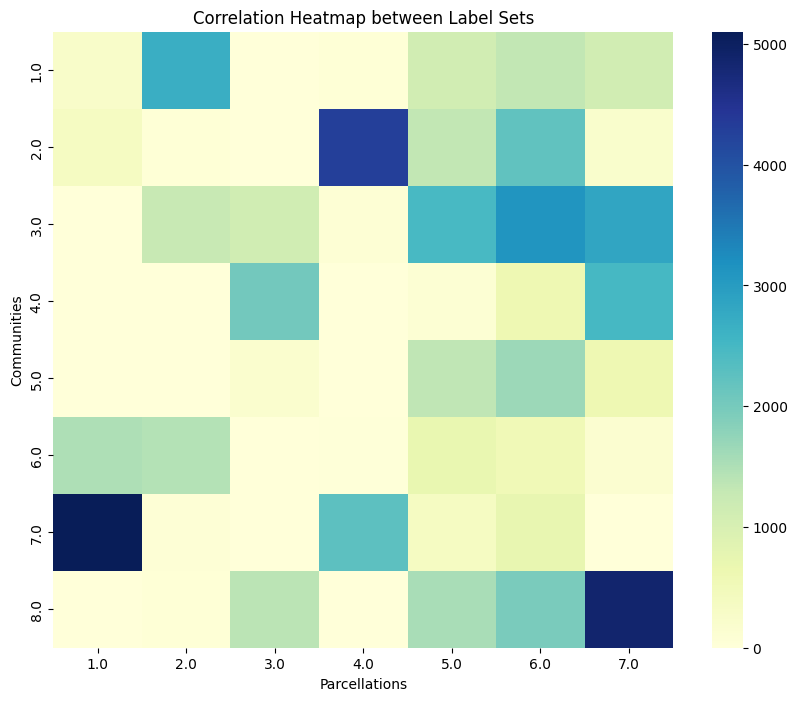

In [79]:

nodes_corr = label_correlation_heatmap(node_list, scale64_list[:len(node_list)])
comm_corr = label_correlation_heatmap(comm_list, scale7_list )

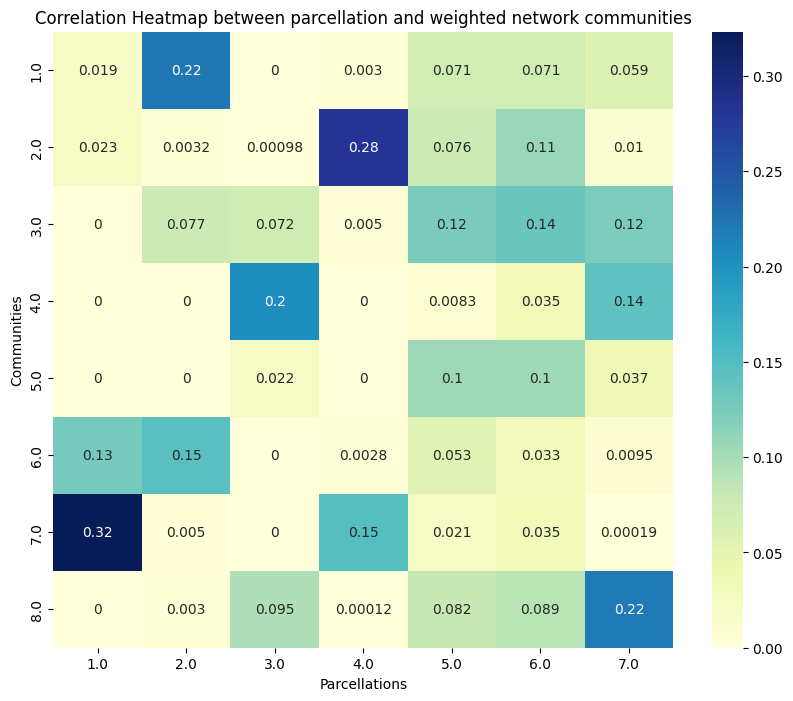

Number of intersections per node:  5.62


/home/daniele/.local/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


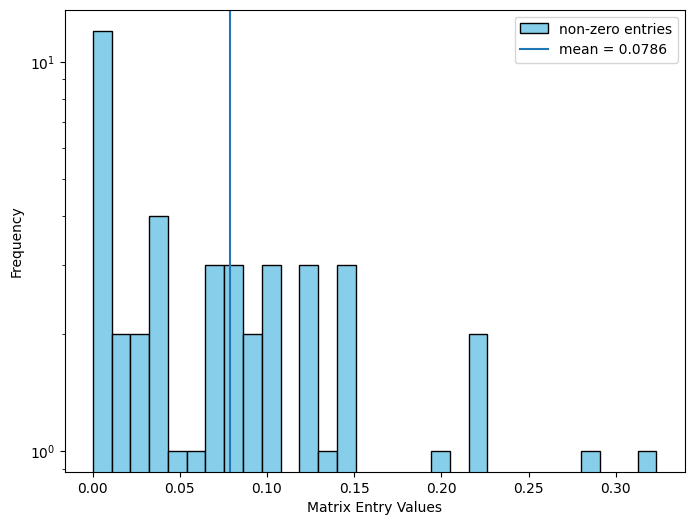

In [101]:

norm_w_comm_to_parc = normalize_contingency_table(comm_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(norm_w_comm_to_parc, annot=True,  cmap="YlGnBu", cbar=True)
plt.xlabel("Parcellations")
plt.ylabel("Communities")
plt.title("Correlation Heatmap between parcellation and weighted network communities")
plt.show()

values= norm_w_comm_to_parc.values.flatten()
values = values[values != 0]
print('Number of intersections per node: ', str(round(len(values)/8,2)))
plot_matrix_histogram(norm_w_comm_to_parc)

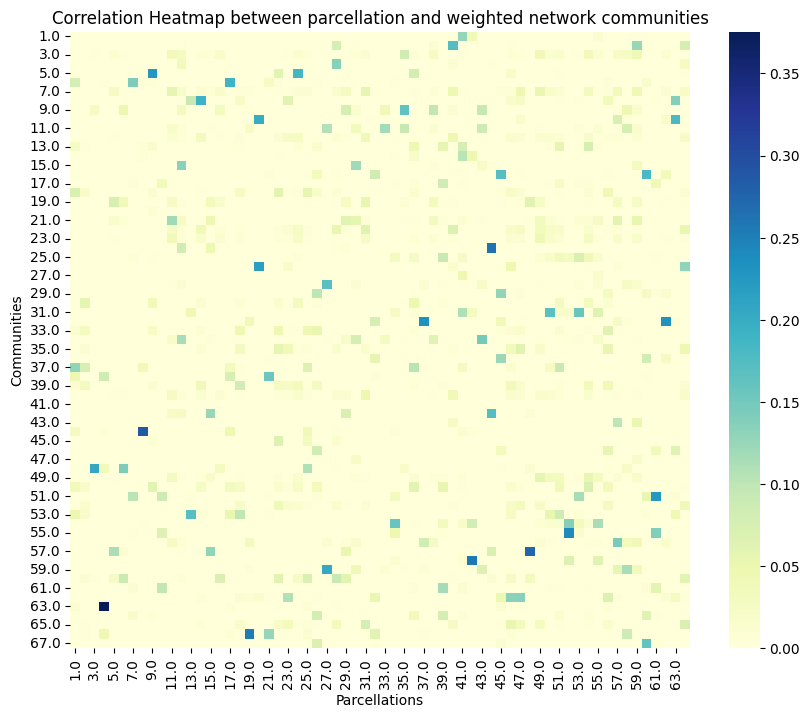

Number of intersections per node:  14.39


/home/daniele/.local/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


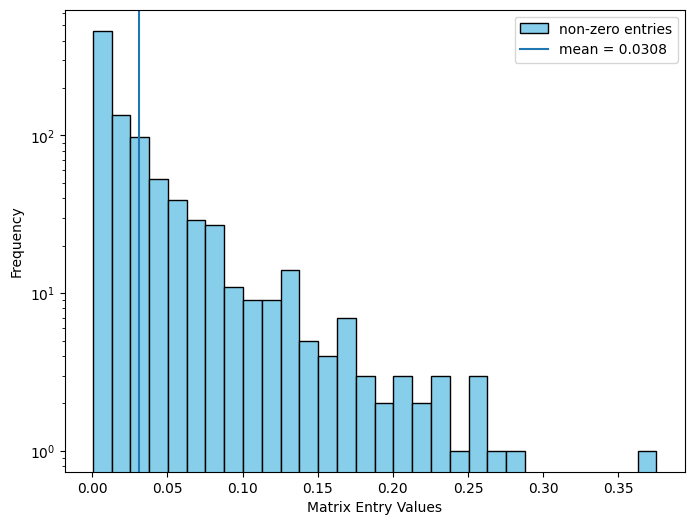

In [98]:

norm_w_comm_to_parc = normalize_contingency_table(nodes_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(norm_w_comm_to_parc, annot=False, fmt="d", cmap="YlGnBu", cbar=True)
plt.xlabel("Parcellations")
plt.ylabel("Communities")
plt.title("Correlation Heatmap between parcellation and weighted network communities")
plt.show()

values= norm_w_comm_to_parc.values.flatten()
values = values[values != 0]
print('Number of intersections per node: ', str(round(len(values)/64,2)))
plot_matrix_histogram(norm_w_comm_to_parc)